In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)
library(ggplot2)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [9]:
url <- "https://raw.githubusercontent.com/szulkifl/dsci-data-analysis-project-44/main/processed.hungarian.data.txt"
hungarian_data <- read_csv(url, col_names= c("age", "sex", "cp", "trestbps", 
                                             "chol", "fbs", "restecg", "thalac", "exang", "oldpeak", 
                                             "slope", "ca", "thal", "num" ),
                          show_col_types = FALSE) |>
                                             mutate(across(where(is.character), ~na_if(.x, "?"))) |> 
                                             mutate(trestbps = as.numeric(trestbps), 
                                                    chol = as.numeric(chol), 
                                                    restecg = as.numeric(restecg),
                                                    thalac = as.numeric(thalac),
                                                    num = as.character(num),
                                                    sex = as.character(sex)) |>
                                             mutate(num = fct_recode(num, "Negative" = "0", "Positive" = "1")) |>
                                             mutate(sex = recode(sex, "1" = "Male", "0" = "Female")) |>
                                             mutate(exang = recode(exang, "0" = "No", "1" = "Yes")) |>
                                            mutate (cp = recode( cp, "1" = "typical angina" , "2" = "atypical angina", 
                                                                "3" = "non-anginal pain", "4" = "asymptomatic" )) |>
                                            mutate (fbs = recode( fbs, "1" = "high fbs", "0" = "normal fbs")) |>
                                            mutate( restcg = recode ( restcg, "0" = "normal" , "1" = "abnormality", "2" = "hypertrophy"))
                                
                                            
hungarian_data

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `restcg = recode(restcg, `0` = "normal", `1` =
  "abnormality", `2` = "hypertrophy")`.
[1mCaused by error:[22m
[33m![39m object 'restcg' not found


# Identifying number of NA readings in all our variables.

In [3]:
nobs <- nrow(hungarian_data)
data_na_df <- hungarian_data |>
              select(cp:thal) |>
              map_df(~sum(is.na(.))) |>
              mutate(across(everything(),~ .x * (100/nobs)))


data_na_df_modified <- pivot_longer(data_na_df,
                                   cp:thal,
                                   names_to = "Variables",
                                   values_to = "Proportions")
dat_na_df_modified_visualized <- data_na_df_modified |>
                                 ggplot(aes(x = Variables, y = Proportions, fill = Variables)) +
                                 geom_bar(stat = "identity") +
                                 scale_fill_brewer(palette = "Blues") +
                                 theme(text = element_text(size = 15))

print("The number of observations in this dataset is:")
print(nobs)
#data_na_df
#dat_na_df_modified_visualized
print(data_na_df_modified)

[1] "The number of observations in this dataset is:"
[1] 294
# A tibble: 11 × 2
   Variables Proportions
   <chr>           <dbl>
 1 cp              0    
 2 trestbps        0.340
 3 chol            7.82 
 4 fbs             2.72 
 5 restecg         0.340
 6 thalac          0.340
 7 exang           0.340
 8 oldpeak         0    
 9 slope          64.6  
10 ca             99.0  
11 thal           90.5  


# Inference:
As shown using the table and visualization above, that variables for ca, slope and thal have the largest proportion of missing entries, which is why it is reasonable for us to ignore them in our data analysis.

# Visualization: 1

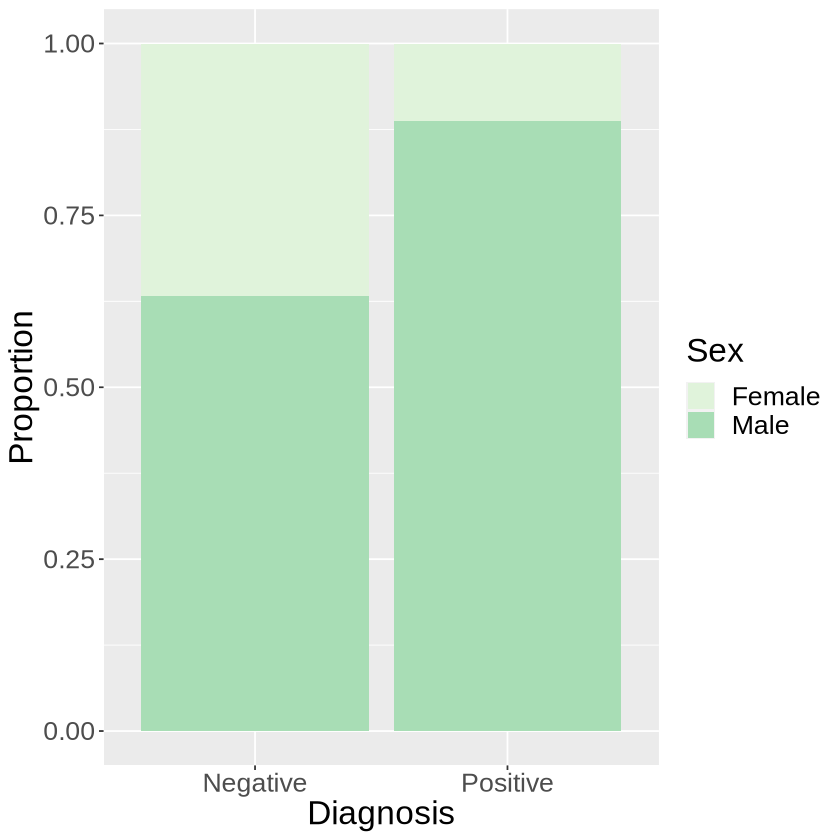

In [4]:
visualize_1 <- hungarian_data |>
               ggplot(aes(x = num, fill = sex)) +
               geom_bar(position = "fill") +
               labs(x = "Diagnosis", y = "Proportion", fill = "Sex") +
               scale_fill_brewer(palette = "GnBu") + 
               theme(text = element_text(size = 20))
visualize_1

# Visualization:2
Distribution of Resting Blood Pressure on Admission (measured in mm) for patients with a negative and positive diagnosis separated.

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


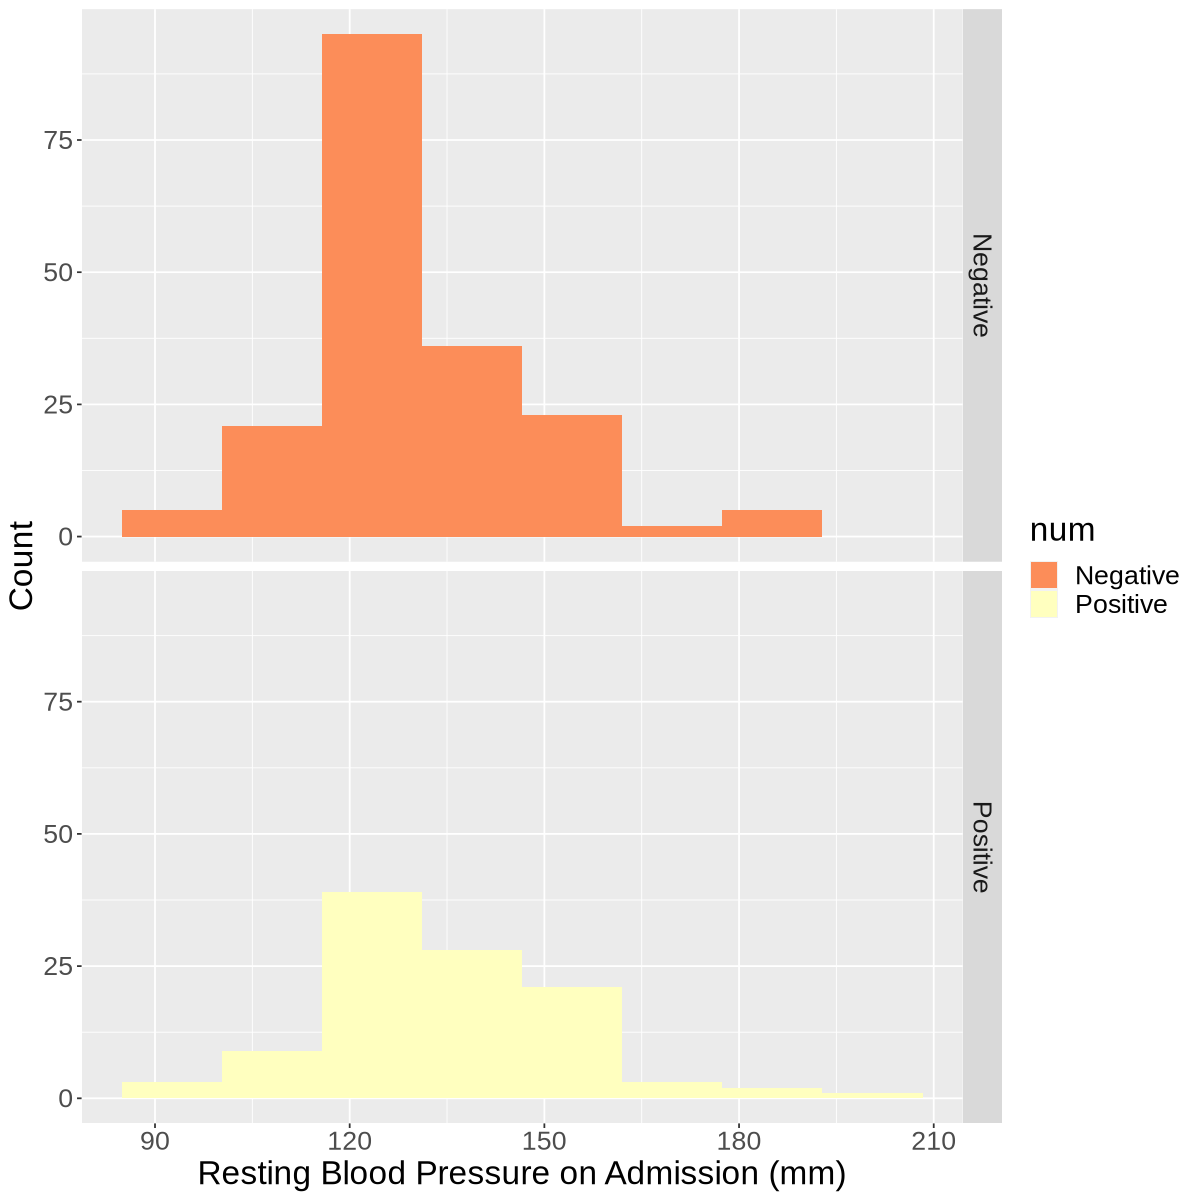

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)
hist_visualiz_trestbps <- hungarian_data |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = trestbps, fill = num)) +
                 geom_histogram(bins = 8) +
                 facet_grid(rows = vars(num)) +
                 labs(x = "Resting Blood Pressure on Admission (mm)", y = "Count", color = "Diagnosis") +
                 scale_fill_brewer(palette = "RdYlGn") + 
                 theme(text = element_text(size = 20))
                 
hist_visualiz_trestbps

# Vizualization:3
Distribution of Cholesterol levels for patients diagnosed Negatively followed by patients diagnosed Positiviely.

Warning message:
“Removed 23 rows containing non-finite values (`stat_bin()`).”


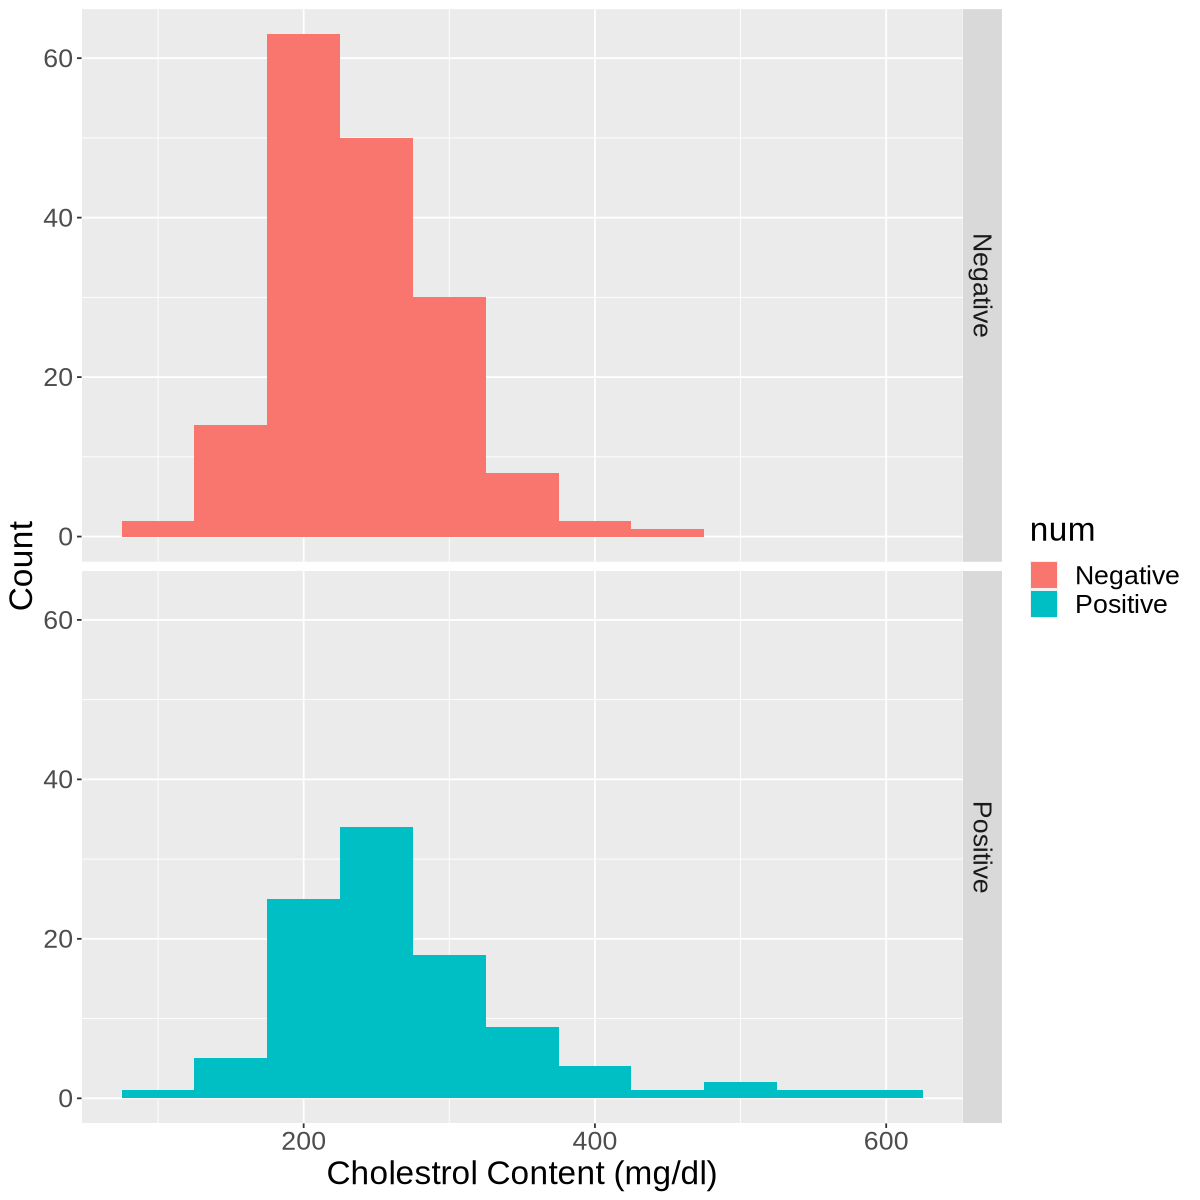

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10)
hist_visualiz_chol <- hungarian_data |>
                 arrange(desc(age))  |>
                 ggplot(aes(x = chol, fill = num)) +
                 geom_histogram(binwidth = 50) +
                 facet_grid(rows = vars(num)) +
                 labs(x = "Cholestrol Content (mg/dl)", y = "Count", color = "Diagnosis") + 
                 theme(text = element_text(size = 20))
                 
hist_visualiz_chol

# Visualization: 4

In [7]:
visualize_

ERROR: Error in eval(expr, envir, enclos): object 'visualize_' not found
